In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
import shutil
import os
import warnings
import dnds_calculations as dnds


# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
inputimage = "final_mosaic.fits"
catalog = inputimage.replace('.fits', '.pybdsf.srl.fits')
# dnds.run_pybdsf_residual(inputimage)
residual_image = inputimage.replace('.fits', '.pybdsf_gaus_resid.fits') 
residual_image = 'gaus_resid.fits' 
modified_image = "modified_residual.fits"
output_npz = 'completeness_corrections_aegean.npz'
# output_npz = 'test.npz'

# dnds.run_pybdsf_residual(inputimage)


In [3]:
# pybdsf on residual image. 
# dnds.run_pybdsf(residual_image)
# with fits.open('AAAA.SP2B.PBCOR.pybdsf_gaus_resid.pybdsf.srl.fits') as hdul:
#     orig_data = hdul[1].data
# residual_fluxes = np.array(orig_data['Total_flux'])

In [4]:
# --- Generate valid RA/Dec grid from residual image ---
with fits.open(inputimage, mode='readonly') as hdu:
    header = hdu[0].header
    wcs = WCS(header, naxis=2)
    data = hdu[0].data.astype(np.float64)

if data.ndim == 4:
    base_data = data[0, 0]
elif data.ndim == 3:
    base_data = data[0]
elif data.ndim == 2:
    base_data = data
else:
    raise ValueError(f"Unexpected FITS dimensions: {data.shape}")

valid_pixels = np.argwhere(~np.isnan(base_data))
valid_ra, valid_dec = wcs.all_pix2world(valid_pixels[:, 1], valid_pixels[:, 0], 0)

# --- Read original fluxes to define bins ---
with fits.open(catalog) as hdul:
    orig_data = hdul[1].data
original_fluxes = np.array(orig_data['Total_flux'])

# Define flux range and bins
# flux_min, flux_max = 0.01, 20  # Jy; adjust as needed
flux_min, flux_max = original_fluxes.min(), original_fluxes.max()
bins = 11
# flux_bins = np.logspace(np.log10(flux_min), np.log10(flux_max), bins+1)
# bin_centers = (flux_bins[:-1] + flux_bins[1:]) / 2
flux_bins, bin_centers, counts, bin_edges, bin_widths = dnds.compute_histogram(original_fluxes, bins)


# --- Simulation parameters ---
NN = 100  # number of realizations
seeds = np.random.RandomState(42).randint(1, 1000, size=NN)
extended_fraction = 0.25

# Placeholder arrays
counts_recovered = np.zeros((NN, bins-1))
counts_injected = np.zeros((NN, bins-1))
# counts_injected = np.zeros(bins)



Set OBSGEO-B to    19.090653 from OBSGEO-[XYZ].
Set OBSGEO-H to      636.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
num_sources = len(original_fluxes)

for i in range(NN):
    print(f"Iteration {i+1}/{NN}")
    
    # Either generate mock fluxes OR use real ones — pick one
    flux_dens, is_ext = dnds.generate_mock_sources(num_sources, flux_min, flux_max, extended_fraction, seed=seeds[i])
    # flux_dens = original_fluxes.copy()
    is_ext = np.random.rand(len(flux_dens)) < extended_fraction

    # Record injected counts
    counts_injected[i], _ = np.histogram(flux_dens, bins=flux_bins)

    # Create synthetic catalog
    inj_flux, inj_ra, inj_dec = dnds.generate_synthetic_catalog(
        catalog, 'synthetic.vot', flux_dens, is_ext, valid_ra, valid_dec, seed=seeds[i]
    )

    # Reset residual image
    shutil.copy(residual_image, modified_image)

    # Inject and recover
    os.system(f"AeRes --add -c synthetic.vot -f {residual_image} -r {modified_image}")
    dnds.run_pybdsf(modified_image)

    # Read recovered catalog
    with fits.open(modified_image.replace('.fits', '.pybdsf.srl.fits')) as hd:
        rec = hd[1].data
        rec_flux = np.array(rec['Total_flux'])
        rec_ra = np.array(rec['RA'])
        rec_dec = np.array(rec['DEC'])

    # Match
    inj_idx, rec_idx = dnds.match_recovered_sources(inj_ra, inj_dec, rec_ra, rec_dec)

    # Histogram matched injected fluxes
    matched_inj_flux = inj_flux[inj_idx]
    counts_recovered[i], _ = np.histogram(matched_inj_flux, bins=flux_bins)


Iteration 1/100
Generated 640 synthetic sources


3394540:INFO This is AeRes v0.2.7-(2020-07-30)
3394540:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3394540:INFO Reading file synthetic.vot
3394540:INFO read 640 sources from synthetic.vot
3394540:INFO modeled 640 sources
3394540:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 2/100
Generated 640 synthetic sources


3395725:INFO This is AeRes v0.2.7-(2020-07-30)
3395725:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3395725:INFO Reading file synthetic.vot
3395725:INFO read 640 sources from synthetic.vot
3395725:INFO modeled 640 sources
3395725:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 3/100
Generated 640 synthetic sources


3397210:INFO This is AeRes v0.2.7-(2020-07-30)
3397210:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3397210:INFO Reading file synthetic.vot
3397210:INFO read 640 sources from synthetic.vot
3397210:INFO modeled 640 sources
3397210:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 4/100
Generated 640 synthetic sources


3398392:INFO This is AeRes v0.2.7-(2020-07-30)
3398392:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3398392:INFO Reading file synthetic.vot
3398392:INFO read 640 sources from synthetic.vot
3398392:INFO modeled 640 sources
3398392:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 5/100
Generated 640 synthetic sources


3399905:INFO This is AeRes v0.2.7-(2020-07-30)
3399905:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3399905:INFO Reading file synthetic.vot
3399905:INFO read 640 sources from synthetic.vot
3399905:INFO modeled 640 sources
3399905:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 6/100
Generated 640 synthetic sources


3401118:INFO This is AeRes v0.2.7-(2020-07-30)
3401118:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3401118:INFO Reading file synthetic.vot
3401118:INFO read 640 sources from synthetic.vot
3401118:INFO modeled 640 sources
3401118:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 7/100
Generated 640 synthetic sources


3402298:INFO This is AeRes v0.2.7-(2020-07-30)
3402298:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3402298:INFO Reading file synthetic.vot
3402298:INFO read 640 sources from synthetic.vot
3402298:INFO modeled 640 sources
3402298:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 8/100
Generated 640 synthetic sources


3403441:INFO This is AeRes v0.2.7-(2020-07-30)
3403441:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3403441:INFO Reading file synthetic.vot
3403441:INFO read 640 sources from synthetic.vot
3403441:INFO modeled 640 sources
3403441:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 9/100
Generated 640 synthetic sources


3404590:INFO This is AeRes v0.2.7-(2020-07-30)
3404590:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3404590:INFO Reading file synthetic.vot
3404590:INFO read 640 sources from synthetic.vot
3404590:INFO modeled 640 sources
3404590:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 10/100
Generated 640 synthetic sources


3405738:INFO This is AeRes v0.2.7-(2020-07-30)
3405738:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3405738:INFO Reading file synthetic.vot
3405738:INFO read 640 sources from synthetic.vot
3405738:INFO modeled 640 sources
3405738:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 11/100
Generated 640 synthetic sources


3406883:INFO This is AeRes v0.2.7-(2020-07-30)
3406883:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3406883:INFO Reading file synthetic.vot
3406883:INFO read 640 sources from synthetic.vot
3406883:INFO modeled 640 sources
3406883:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 12/100
Generated 640 synthetic sources


3408033:INFO This is AeRes v0.2.7-(2020-07-30)
3408033:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3408033:INFO Reading file synthetic.vot
3408033:INFO read 640 sources from synthetic.vot
3408033:INFO modeled 640 sources
3408033:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 13/100
Generated 640 synthetic sources


3409277:INFO This is AeRes v0.2.7-(2020-07-30)
3409277:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3409277:INFO Reading file synthetic.vot
3409277:INFO read 640 sources from synthetic.vot
3409277:INFO modeled 640 sources
3409277:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 14/100
Generated 640 synthetic sources


3410484:INFO This is AeRes v0.2.7-(2020-07-30)
3410484:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3410484:INFO Reading file synthetic.vot
3410484:INFO read 640 sources from synthetic.vot
3410484:INFO modeled 640 sources
3410484:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 15/100
Generated 640 synthetic sources


3411645:INFO This is AeRes v0.2.7-(2020-07-30)
3411645:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3411645:INFO Reading file synthetic.vot
3411645:INFO read 640 sources from synthetic.vot
3411645:INFO modeled 640 sources
3411645:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 16/100
Generated 640 synthetic sources


3412790:INFO This is AeRes v0.2.7-(2020-07-30)
3412790:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3412790:INFO Reading file synthetic.vot
3412790:INFO read 640 sources from synthetic.vot
3412790:INFO modeled 640 sources
3412790:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 17/100
Generated 640 synthetic sources


3413936:INFO This is AeRes v0.2.7-(2020-07-30)
3413936:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3413936:INFO Reading file synthetic.vot
3413936:INFO read 640 sources from synthetic.vot
3413936:INFO modeled 640 sources
3413936:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 18/100
Generated 640 synthetic sources


3415087:INFO This is AeRes v0.2.7-(2020-07-30)
3415087:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3415087:INFO Reading file synthetic.vot
3415087:INFO read 640 sources from synthetic.vot
3415087:INFO modeled 640 sources
3415087:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 19/100
Generated 640 synthetic sources


3416244:INFO This is AeRes v0.2.7-(2020-07-30)
3416244:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3416244:INFO Reading file synthetic.vot
3416244:INFO read 640 sources from synthetic.vot
3416244:INFO modeled 640 sources
3416244:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 20/100
Generated 640 synthetic sources


3417396:INFO This is AeRes v0.2.7-(2020-07-30)
3417396:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3417396:INFO Reading file synthetic.vot
3417396:INFO read 640 sources from synthetic.vot
3417396:INFO modeled 640 sources
3417396:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 21/100
Generated 640 synthetic sources


3418550:INFO This is AeRes v0.2.7-(2020-07-30)
3418550:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3418550:INFO Reading file synthetic.vot
3418550:INFO read 640 sources from synthetic.vot
3418550:INFO modeled 640 sources
3418550:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 22/100
Generated 640 synthetic sources


3419721:INFO This is AeRes v0.2.7-(2020-07-30)
3419721:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3419721:INFO Reading file synthetic.vot
3419721:INFO read 640 sources from synthetic.vot
3419721:INFO modeled 640 sources
3419721:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 23/100
Generated 640 synthetic sources


3420914:INFO This is AeRes v0.2.7-(2020-07-30)
3420914:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3420914:INFO Reading file synthetic.vot
3420914:INFO read 640 sources from synthetic.vot
3420914:INFO modeled 640 sources
3420914:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 24/100
Generated 640 synthetic sources


3422126:INFO This is AeRes v0.2.7-(2020-07-30)
3422126:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3422126:INFO Reading file synthetic.vot
3422126:INFO read 640 sources from synthetic.vot
3422126:INFO modeled 640 sources
3422126:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 25/100
Generated 640 synthetic sources


3423278:INFO This is AeRes v0.2.7-(2020-07-30)
3423278:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3423278:INFO Reading file synthetic.vot
3423278:INFO read 640 sources from synthetic.vot
3423278:INFO modeled 640 sources
3423278:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 26/100
Generated 640 synthetic sources


3424429:INFO This is AeRes v0.2.7-(2020-07-30)
3424429:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3424429:INFO Reading file synthetic.vot
3424429:INFO read 640 sources from synthetic.vot
3424429:INFO modeled 640 sources
3424429:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 27/100
Generated 640 synthetic sources


3425579:INFO This is AeRes v0.2.7-(2020-07-30)
3425579:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3425579:INFO Reading file synthetic.vot
3425579:INFO read 640 sources from synthetic.vot
3425579:INFO modeled 640 sources
3425579:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 28/100
Generated 640 synthetic sources


3426762:INFO This is AeRes v0.2.7-(2020-07-30)
3426762:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3426762:INFO Reading file synthetic.vot
3426762:INFO read 640 sources from synthetic.vot
3426762:INFO modeled 640 sources
3426762:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 29/100
Generated 640 synthetic sources


3427961:INFO This is AeRes v0.2.7-(2020-07-30)
3427961:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3427961:INFO Reading file synthetic.vot
3427961:INFO read 640 sources from synthetic.vot
3427961:INFO modeled 640 sources
3427961:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 30/100
Generated 640 synthetic sources


3429111:INFO This is AeRes v0.2.7-(2020-07-30)
3429111:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3429111:INFO Reading file synthetic.vot
3429111:INFO read 640 sources from synthetic.vot
3429111:INFO modeled 640 sources
3429111:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 31/100
Generated 640 synthetic sources


3430293:INFO This is AeRes v0.2.7-(2020-07-30)
3430293:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3430293:INFO Reading file synthetic.vot
3430293:INFO read 640 sources from synthetic.vot
3430293:INFO modeled 640 sources
3430293:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 32/100
Generated 640 synthetic sources


3431464:INFO This is AeRes v0.2.7-(2020-07-30)
3431464:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3431464:INFO Reading file synthetic.vot
3431464:INFO read 640 sources from synthetic.vot
3431464:INFO modeled 640 sources
3431464:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 33/100
Generated 640 synthetic sources


3432618:INFO This is AeRes v0.2.7-(2020-07-30)
3432618:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3432618:INFO Reading file synthetic.vot
3432618:INFO read 640 sources from synthetic.vot
3432618:INFO modeled 640 sources
3432618:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 34/100
Generated 640 synthetic sources


3433843:INFO This is AeRes v0.2.7-(2020-07-30)
3433843:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3433843:INFO Reading file synthetic.vot
3433843:INFO read 640 sources from synthetic.vot
3433843:INFO modeled 640 sources
3433843:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 35/100
Generated 640 synthetic sources


3435003:INFO This is AeRes v0.2.7-(2020-07-30)
3435003:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3435003:INFO Reading file synthetic.vot
3435003:INFO read 640 sources from synthetic.vot
3435003:INFO modeled 640 sources
3435003:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 36/100
Generated 640 synthetic sources


3436153:INFO This is AeRes v0.2.7-(2020-07-30)
3436153:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3436153:INFO Reading file synthetic.vot
3436153:INFO read 640 sources from synthetic.vot
3436153:INFO modeled 640 sources
3436153:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 37/100
Generated 640 synthetic sources


3437300:INFO This is AeRes v0.2.7-(2020-07-30)
3437300:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3437300:INFO Reading file synthetic.vot
3437300:INFO read 640 sources from synthetic.vot
3437300:INFO modeled 640 sources
3437300:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 38/100
Generated 640 synthetic sources


3438460:INFO This is AeRes v0.2.7-(2020-07-30)
3438460:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3438460:INFO Reading file synthetic.vot
3438460:INFO read 640 sources from synthetic.vot
3438460:INFO modeled 640 sources
3438460:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 39/100
Generated 640 synthetic sources


3439654:INFO This is AeRes v0.2.7-(2020-07-30)
3439654:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3439654:INFO Reading file synthetic.vot
3439654:INFO read 640 sources from synthetic.vot
3439654:INFO modeled 640 sources
3439654:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 40/100
Generated 640 synthetic sources


3440833:INFO This is AeRes v0.2.7-(2020-07-30)
3440833:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3440833:INFO Reading file synthetic.vot
3440833:INFO read 640 sources from synthetic.vot
3440833:INFO modeled 640 sources
3440833:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 41/100
Generated 640 synthetic sources


3441981:INFO This is AeRes v0.2.7-(2020-07-30)
3441981:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3441981:INFO Reading file synthetic.vot
3441981:INFO read 640 sources from synthetic.vot
3441981:INFO modeled 640 sources
3441981:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 42/100
Generated 640 synthetic sources


3443148:INFO This is AeRes v0.2.7-(2020-07-30)
3443148:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3443148:INFO Reading file synthetic.vot
3443148:INFO read 640 sources from synthetic.vot
3443148:INFO modeled 640 sources
3443148:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 43/100
Generated 640 synthetic sources


3444313:INFO This is AeRes v0.2.7-(2020-07-30)
3444313:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3444313:INFO Reading file synthetic.vot
3444313:INFO read 640 sources from synthetic.vot
3444313:INFO modeled 640 sources
3444313:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 44/100
Generated 640 synthetic sources


3445549:INFO This is AeRes v0.2.7-(2020-07-30)
3445549:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3445549:INFO Reading file synthetic.vot
3445549:INFO read 640 sources from synthetic.vot
3445549:INFO modeled 640 sources
3445549:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 45/100
Generated 640 synthetic sources


3446709:INFO This is AeRes v0.2.7-(2020-07-30)
3446709:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3446709:INFO Reading file synthetic.vot
3446709:INFO read 640 sources from synthetic.vot
3446709:INFO modeled 640 sources
3446709:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 46/100
Generated 640 synthetic sources


3447860:INFO This is AeRes v0.2.7-(2020-07-30)
3447860:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3447860:INFO Reading file synthetic.vot
3447860:INFO read 640 sources from synthetic.vot
3447860:INFO modeled 640 sources
3447860:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 47/100
Generated 640 synthetic sources


3449022:INFO This is AeRes v0.2.7-(2020-07-30)
3449022:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3449022:INFO Reading file synthetic.vot
3449022:INFO read 640 sources from synthetic.vot
3449022:INFO modeled 640 sources
3449022:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 48/100
Generated 640 synthetic sources


3450200:INFO This is AeRes v0.2.7-(2020-07-30)
3450200:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3450200:INFO Reading file synthetic.vot
3450200:INFO read 640 sources from synthetic.vot
3450200:INFO modeled 640 sources
3450200:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 49/100
Generated 640 synthetic sources


3451416:INFO This is AeRes v0.2.7-(2020-07-30)
3451416:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3451416:INFO Reading file synthetic.vot
3451416:INFO read 640 sources from synthetic.vot
3451416:INFO modeled 640 sources
3451416:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 50/100
Generated 640 synthetic sources


3452731:INFO This is AeRes v0.2.7-(2020-07-30)
3452731:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3452731:INFO Reading file synthetic.vot
3452731:INFO read 640 sources from synthetic.vot
3452731:INFO modeled 640 sources
3452731:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 51/100
Generated 640 synthetic sources


3454008:INFO This is AeRes v0.2.7-(2020-07-30)
3454008:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3454008:INFO Reading file synthetic.vot
3454008:INFO read 640 sources from synthetic.vot
3454008:INFO modeled 640 sources
3454008:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 52/100
Generated 640 synthetic sources


3455157:INFO This is AeRes v0.2.7-(2020-07-30)
3455157:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3455157:INFO Reading file synthetic.vot
3455157:INFO read 640 sources from synthetic.vot
3455157:INFO modeled 640 sources
3455157:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 53/100
Generated 640 synthetic sources


3456334:INFO This is AeRes v0.2.7-(2020-07-30)
3456334:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3456334:INFO Reading file synthetic.vot
3456334:INFO read 640 sources from synthetic.vot
3456334:INFO modeled 640 sources
3456334:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 54/100
Generated 640 synthetic sources


3457487:INFO This is AeRes v0.2.7-(2020-07-30)
3457487:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3457487:INFO Reading file synthetic.vot
3457487:INFO read 640 sources from synthetic.vot
3457487:INFO modeled 640 sources
3457487:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 55/100
Generated 640 synthetic sources


3458648:INFO This is AeRes v0.2.7-(2020-07-30)
3458648:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3458648:INFO Reading file synthetic.vot
3458648:INFO read 640 sources from synthetic.vot
3458648:INFO modeled 640 sources
3458648:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 56/100
Generated 640 synthetic sources


3459835:INFO This is AeRes v0.2.7-(2020-07-30)
3459835:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3459835:INFO Reading file synthetic.vot
3459835:INFO read 640 sources from synthetic.vot
3459835:INFO modeled 640 sources
3459835:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 57/100
Generated 640 synthetic sources


3460989:INFO This is AeRes v0.2.7-(2020-07-30)
3460989:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3460989:INFO Reading file synthetic.vot
3460989:INFO read 640 sources from synthetic.vot
3460989:INFO modeled 640 sources
3460989:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 58/100
Generated 640 synthetic sources


3462136:INFO This is AeRes v0.2.7-(2020-07-30)
3462136:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3462136:INFO Reading file synthetic.vot
3462136:INFO read 640 sources from synthetic.vot
3462136:INFO modeled 640 sources
3462136:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 59/100
Generated 640 synthetic sources


3463288:INFO This is AeRes v0.2.7-(2020-07-30)
3463288:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3463288:INFO Reading file synthetic.vot
3463288:INFO read 640 sources from synthetic.vot
3463288:INFO modeled 640 sources
3463288:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 60/100
Generated 640 synthetic sources


3464443:INFO This is AeRes v0.2.7-(2020-07-30)
3464443:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3464443:INFO Reading file synthetic.vot
3464443:INFO read 640 sources from synthetic.vot
3464443:INFO modeled 640 sources
3464443:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 61/100
Generated 640 synthetic sources


3465598:INFO This is AeRes v0.2.7-(2020-07-30)
3465598:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3465598:INFO Reading file synthetic.vot
3465598:INFO read 640 sources from synthetic.vot
3465598:INFO modeled 640 sources
3465598:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 62/100
Generated 640 synthetic sources


3466744:INFO This is AeRes v0.2.7-(2020-07-30)
3466744:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3466744:INFO Reading file synthetic.vot
3466744:INFO read 640 sources from synthetic.vot
3466744:INFO modeled 640 sources
3466744:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 63/100
Generated 640 synthetic sources


3467969:INFO This is AeRes v0.2.7-(2020-07-30)
3467969:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3467969:INFO Reading file synthetic.vot
3467969:INFO read 640 sources from synthetic.vot
3467969:INFO modeled 640 sources
3467969:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 64/100
Generated 640 synthetic sources


3469149:INFO This is AeRes v0.2.7-(2020-07-30)
3469149:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3469149:INFO Reading file synthetic.vot
3469149:INFO read 640 sources from synthetic.vot
3469149:INFO modeled 640 sources
3469149:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 65/100
Generated 640 synthetic sources


3470432:INFO This is AeRes v0.2.7-(2020-07-30)
3470432:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3470432:INFO Reading file synthetic.vot
3470432:INFO read 640 sources from synthetic.vot
3470432:INFO modeled 640 sources
3470432:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 66/100
Generated 640 synthetic sources


3471595:INFO This is AeRes v0.2.7-(2020-07-30)
3471595:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3471595:INFO Reading file synthetic.vot
3471595:INFO read 640 sources from synthetic.vot
3471595:INFO modeled 640 sources
3471595:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 67/100
Generated 640 synthetic sources


3472747:INFO This is AeRes v0.2.7-(2020-07-30)
3472747:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3472747:INFO Reading file synthetic.vot
3472747:INFO read 640 sources from synthetic.vot
3472747:INFO modeled 640 sources
3472747:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 68/100
Generated 640 synthetic sources


3473902:INFO This is AeRes v0.2.7-(2020-07-30)
3473902:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3473902:INFO Reading file synthetic.vot
3473902:INFO read 640 sources from synthetic.vot
3473902:INFO modeled 640 sources
3473902:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 69/100
Generated 640 synthetic sources


3475047:INFO This is AeRes v0.2.7-(2020-07-30)
3475047:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3475047:INFO Reading file synthetic.vot
3475047:INFO read 640 sources from synthetic.vot
3475047:INFO modeled 640 sources
3475047:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 70/100
Generated 640 synthetic sources


3476216:INFO This is AeRes v0.2.7-(2020-07-30)
3476216:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3476216:INFO Reading file synthetic.vot
3476216:INFO read 640 sources from synthetic.vot
3476216:INFO modeled 640 sources
3476216:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 71/100
Generated 640 synthetic sources


3477376:INFO This is AeRes v0.2.7-(2020-07-30)
3477376:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3477376:INFO Reading file synthetic.vot
3477376:INFO read 640 sources from synthetic.vot
3477376:INFO modeled 640 sources
3477376:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 72/100
Generated 640 synthetic sources


3478538:INFO This is AeRes v0.2.7-(2020-07-30)
3478538:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3478538:INFO Reading file synthetic.vot
3478538:INFO read 640 sources from synthetic.vot
3478538:INFO modeled 640 sources
3478538:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 73/100
Generated 640 synthetic sources


3479720:INFO This is AeRes v0.2.7-(2020-07-30)
3479720:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3479720:INFO Reading file synthetic.vot
3479720:INFO read 640 sources from synthetic.vot
3479720:INFO modeled 640 sources
3479720:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
/home/asif/miniconda3/lib/python3.12/site-packages/bdsf/functions.py:624: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  p, success = leastsq(errorfunction, p_ini)
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 74/100
Generated 640 synthetic sources


3480872:INFO This is AeRes v0.2.7-(2020-07-30)
3480872:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3480872:INFO Reading file synthetic.vot
3480872:INFO read 640 sources from synthetic.vot
3480872:INFO modeled 640 sources
3480872:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 75/100
Generated 640 synthetic sources


3482034:INFO This is AeRes v0.2.7-(2020-07-30)
3482034:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3482034:INFO Reading file synthetic.vot
3482034:INFO read 640 sources from synthetic.vot
3482034:INFO modeled 640 sources
3482034:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 76/100
Generated 640 synthetic sources


3483232:INFO This is AeRes v0.2.7-(2020-07-30)
3483232:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3483232:INFO Reading file synthetic.vot
3483232:INFO read 640 sources from synthetic.vot
3483232:INFO modeled 640 sources
3483232:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 77/100
Generated 640 synthetic sources


3484374:INFO This is AeRes v0.2.7-(2020-07-30)
3484374:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3484374:INFO Reading file synthetic.vot
3484374:INFO read 640 sources from synthetic.vot
3484374:INFO modeled 640 sources
3484374:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 78/100
Generated 640 synthetic sources


3485522:INFO This is AeRes v0.2.7-(2020-07-30)
3485522:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3485522:INFO Reading file synthetic.vot
3485522:INFO read 640 sources from synthetic.vot
3485522:INFO modeled 640 sources
3485522:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 79/100
Generated 640 synthetic sources


3486668:INFO This is AeRes v0.2.7-(2020-07-30)
3486668:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3486668:INFO Reading file synthetic.vot
3486668:INFO read 640 sources from synthetic.vot
3486668:INFO modeled 640 sources
3486668:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 80/100
Generated 640 synthetic sources


3487825:INFO This is AeRes v0.2.7-(2020-07-30)
3487825:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3487825:INFO Reading file synthetic.vot
3487825:INFO read 640 sources from synthetic.vot
3487825:INFO modeled 640 sources
3487825:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 81/100
Generated 640 synthetic sources


3488989:INFO This is AeRes v0.2.7-(2020-07-30)
3488989:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3488989:INFO Reading file synthetic.vot
3488989:INFO read 640 sources from synthetic.vot
3488989:INFO modeled 640 sources
3488989:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 82/100
Generated 640 synthetic sources


3490168:INFO This is AeRes v0.2.7-(2020-07-30)
3490168:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3490168:INFO Reading file synthetic.vot
3490168:INFO read 640 sources from synthetic.vot
3490168:INFO modeled 640 sources
3490168:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 83/100
Generated 640 synthetic sources


3491331:INFO This is AeRes v0.2.7-(2020-07-30)
3491331:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3491331:INFO Reading file synthetic.vot
3491331:INFO read 640 sources from synthetic.vot
3491331:INFO modeled 640 sources
3491331:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 84/100
Generated 640 synthetic sources


3492472:INFO This is AeRes v0.2.7-(2020-07-30)
3492472:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3492472:INFO Reading file synthetic.vot
3492472:INFO read 640 sources from synthetic.vot
3492472:INFO modeled 640 sources
3492472:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 85/100
Generated 640 synthetic sources


3493629:INFO This is AeRes v0.2.7-(2020-07-30)
3493629:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3493629:INFO Reading file synthetic.vot
3493629:INFO read 640 sources from synthetic.vot
3493629:INFO modeled 640 sources
3493629:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 86/100
Generated 640 synthetic sources


3494787:INFO This is AeRes v0.2.7-(2020-07-30)
3494787:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3494787:INFO Reading file synthetic.vot
3494787:INFO read 640 sources from synthetic.vot
3494787:INFO modeled 640 sources
3494787:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 87/100
Generated 640 synthetic sources


3495945:INFO This is AeRes v0.2.7-(2020-07-30)
3495945:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3495945:INFO Reading file synthetic.vot
3495945:INFO read 640 sources from synthetic.vot
3495945:INFO modeled 640 sources
3495945:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 88/100
Generated 640 synthetic sources


3497093:INFO This is AeRes v0.2.7-(2020-07-30)
3497093:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3497093:INFO Reading file synthetic.vot
3497093:INFO read 640 sources from synthetic.vot
3497093:INFO modeled 640 sources
3497093:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
/home/asif/miniconda3/lib/python3.12/site-packages/bdsf/functions.py:624: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  p, success = leastsq(errorfunction, p_ini)
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 89/100
Generated 640 synthetic sources


3498252:INFO This is AeRes v0.2.7-(2020-07-30)
3498252:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3498252:INFO Reading file synthetic.vot
3498252:INFO read 640 sources from synthetic.vot
3498252:INFO modeled 640 sources
3498252:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 90/100
Generated 640 synthetic sources


3499476:INFO This is AeRes v0.2.7-(2020-07-30)
3499476:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3499476:INFO Reading file synthetic.vot
3499476:INFO read 640 sources from synthetic.vot
3499476:INFO modeled 640 sources
3499476:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 91/100
Generated 640 synthetic sources


3500625:INFO This is AeRes v0.2.7-(2020-07-30)
3500625:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3500625:INFO Reading file synthetic.vot
3500625:INFO read 640 sources from synthetic.vot
3500625:INFO modeled 640 sources
3500625:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 92/100
Generated 640 synthetic sources


3501791:INFO This is AeRes v0.2.7-(2020-07-30)
3501791:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3501791:INFO Reading file synthetic.vot
3501791:INFO read 640 sources from synthetic.vot
3501791:INFO modeled 640 sources
3501791:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 93/100
Generated 640 synthetic sources


3502945:INFO This is AeRes v0.2.7-(2020-07-30)
3502945:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3502945:INFO Reading file synthetic.vot
3502945:INFO read 640 sources from synthetic.vot
3502945:INFO modeled 640 sources
3502945:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 94/100
Generated 640 synthetic sources


3504125:INFO This is AeRes v0.2.7-(2020-07-30)
3504125:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3504125:INFO Reading file synthetic.vot
3504125:INFO read 640 sources from synthetic.vot
3504125:INFO modeled 640 sources
3504125:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 95/100
Generated 640 synthetic sources


3505411:INFO This is AeRes v0.2.7-(2020-07-30)
3505411:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3505411:INFO Reading file synthetic.vot
3505411:INFO read 640 sources from synthetic.vot
3505411:INFO modeled 640 sources
3505411:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 96/100
Generated 640 synthetic sources


3506753:INFO This is AeRes v0.2.7-(2020-07-30)
3506753:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3506753:INFO Reading file synthetic.vot
3506753:INFO read 640 sources from synthetic.vot
3506753:INFO modeled 640 sources
3506753:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 97/100
Generated 640 synthetic sources


3507968:INFO This is AeRes v0.2.7-(2020-07-30)
3507968:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3507968:INFO Reading file synthetic.vot
3507968:INFO read 640 sources from synthetic.vot
3507968:INFO modeled 640 sources
3507968:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 98/100
Generated 640 synthetic sources


3509273:INFO This is AeRes v0.2.7-(2020-07-30)
3509273:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3509273:INFO Reading file synthetic.vot
3509273:INFO read 640 sources from synthetic.vot
3509273:INFO modeled 640 sources
3509273:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 99/100
Generated 640 synthetic sources


3510424:INFO This is AeRes v0.2.7-(2020-07-30)
3510424:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3510424:INFO Reading file synthetic.vot
3510424:INFO read 640 sources from synthetic.vot
3510424:INFO modeled 640 sources
3510424:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'
Iteration 100/100
Generated 640 synthetic sources


3511583:INFO This is AeRes v0.2.7-(2020-07-30)
3511583:INFO Using gaus_resid.fits and synthetic.vot to make modified_residual.fits
3511583:INFO Reading file synthetic.vot
3511583:INFO read 640 sources from synthetic.vot
3511583:INFO modeled 640 sources
3511583:INFO wrote residual to modified_residual.fits
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--> Wrote FITS file 'modified_residual.pybdsf.srl.fits'


In [6]:
counts_injected, counts_recovered

# (array([[13., 32., 34., 38., 16.,  8.,  2.,  0.,  0.,  0.],
#         [13., 32., 34., 38., 16.,  8.,  2.,  0.,  0.,  0.]]),
#  array([[ 2., 12., 40., 35., 28., 12.,  6.,  0.,  0.,  0.],
#         [ 1., 14., 36., 37., 29., 14.,  5.,  0.,  0.,  0.]]))

(array([[145., 105.,  67.,  40.,  32.,  18.,  17.,   5.,   2.,   1.],
        [143.,  97.,  61.,  52.,  32.,  20.,   5.,   8.,   7.,   5.],
        [151.,  97.,  58.,  38.,  25.,  18.,  10.,   9.,   2.,   5.],
        [142.,  96.,  72.,  37.,  23.,  17.,   9.,   5.,   5.,   4.],
        [157.,  97.,  59.,  34.,  32.,  21.,  11.,   9.,   8.,   3.],
        [145.,  98.,  66.,  46.,  29.,  19.,  12.,   3.,   5.,   6.],
        [153.,  96.,  64.,  42.,  25.,  21.,  17.,   7.,   4.,   2.],
        [129.,  89.,  71.,  43.,  36.,  17.,  11.,  15.,   5.,   2.],
        [173.,  96.,  65.,  45.,  16.,  20.,   6.,   8.,   3.,   3.],
        [157.,  84.,  70.,  46.,  23.,  12.,   8.,   7.,   5.,   2.],
        [141., 100.,  69.,  45.,  25.,  14.,   9.,  13.,   7.,   6.],
        [141.,  95.,  74.,  49.,  31.,  19.,  14.,   6.,   6.,   1.],
        [142., 100.,  70.,  35.,  25.,  22.,  14.,   8.,   3.,   4.],
        [146.,  98.,  70.,  37.,  27.,  17.,  12.,   7.,   4.,   7.],
        [140.,  97.,

In [7]:
correction_factor_rea = 0.*counts_recovered

for ii in range(NN):
    correction_factor_rea[ii] = np.where(counts_recovered[ii] > 0, counts_injected[ii] / counts_recovered[ii], 1.)


In [8]:
correction_factor_rea

array([[2.04225352, 1.26506024, 1.13559322, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.7875    , 1.32876712, 1.12962963, 1.06122449, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [2.43548387, 1.29333333, 1.09433962, 1.05555556, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [2.40677966, 1.31506849, 1.22033898, 1.        , 1.        ,
        1.0625    , 1.        , 1.        , 1.        , 1.        ],
       [1.9625    , 1.32876712, 1.15686275, 1.03030303, 1.03225806,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.85897436, 1.38028169, 1.03125   , 1.02222222, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [2.15492958, 1.28      , 1.08474576, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [2.04761905, 1.23611111, 1.1451612

In [9]:
# data = correction_factor_rea[:, 3]
# median = np.percentile(data, 50)
# median

In [10]:
correction_factor_rea = 0.*counts_recovered

for ii in range(NN):
    with np.errstate(divide='ignore', invalid='ignore'):
        correction_factor_rea[ii] = np.where(counts_recovered[ii] > 0, counts_injected[ii] / counts_recovered[ii], 1.)

correction_factor_med = np.zeros(bins-1)
correction_factor_low = np.zeros(bins-1)
correction_factor_upp = np.zeros(bins-1)

for ii in range(bins-1):
    data = correction_factor_rea[:, ii]
    median = np.percentile(data, 50)   # 50th percentile (median)
    # median = np.mean(data)   # 50th percentile (median)
    p16 = np.percentile(data, 16)      # 16th percentile
    p84 = np.percentile(data, 84)      # 84th percentile

    correction_factor_med[ii] = median
    correction_factor_low[ii] = median - p16
    correction_factor_upp[ii] = p84 - median
    
    # print(f"Median: {median}")
    # print(f"16th Percentile: {p16}")
    # print(f"84th Percentile: {p84}")

In [11]:
bin_centers, correction_factor_med
# (array([ 0.0334566 ,  0.06401057,  0.12246771,  0.23431036,  0.44829243,
#          0.85769191,  1.6409722 ,  3.13957696,  6.00677056, 11.49240583]),
#  array([13.        ,  2.46153846,  0.89473684,  1.02702703,  0.58201058,
#          0.59340659,  0.33333333,  1.        ,  1.        ,  1.        ]))


(array([ 0.02985883,  0.05929612,  0.11775513,  0.23384787,  0.46439441,
         0.92223277,  1.83144598,  3.63703665,  7.2227277 , 14.34348908]),
 array([2.04761905, 1.30517241, 1.10859951, 1.02325581, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]))

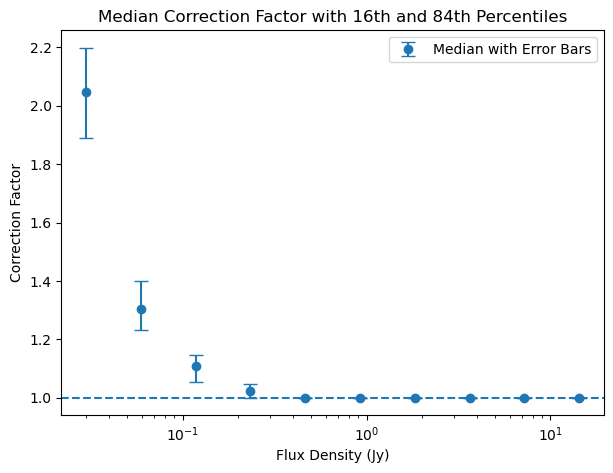

In [12]:
import numpy as np
import matplotlib.pyplot as plt
a1 = 0

# Plot with error bars
plt.figure(figsize=(7, 5))
plt.errorbar(bin_centers[a1:], correction_factor_med[a1:], 
             yerr=[correction_factor_low[a1:], correction_factor_upp[a1:]], 
             fmt='o', capsize=5, label="Median with Error Bars")

# Set log scale for x-axis
plt.xscale("log")
plt.axhline(1.0, ls='--')
# Labels and title
plt.xlabel("Flux Density (Jy)")
plt.ylabel("Correction Factor")
plt.title("Median Correction Factor with 16th and 84th Percentiles")

# Show legend
plt.legend()

# Show plot
plt.show()


In [13]:
# np.savez(output_npz, 
#          bin_centers = bin_centers,
#          med=correction_factor_med, 
#          low=correction_factor_low, 
#          upp=correction_factor_upp)
